In [99]:
import numpy as np
import pandas as pd
import tqdm
import random
import os
import importlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

import src
import src.analysis
importlib.reload(src.analysis)
from src.analysis import Analysis

from src.Config import Config

# Load Data

In [31]:
df = pd.read_csv(r'D:\03-Training\03-SelfLearning\16-Forecasting\MEDIUM_NoteBook-master\Extreme_Event_Forecasting\avocado.csv',index_col=0)
print(df.shape)
df.head()

(18249, 13)


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [34]:
df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [40]:
def plot_seris(county, typ):
    
    plt.figure(figsize=(9,6))
    reg_train = df[(df['type']==typ)&(df['year']!=2018)].groupby('region')
    p_train = reg_train.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(0,len(p_train)), p_train['AveragePrice'].values)
    
    reg_test = df[(df['type']==typ)&(df['year']==2018)].groupby('region')
    p_test = reg_test.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(len(p_train),len(p_train)+len(p_test)),p_test['AveragePrice'].values)
    plt.title('AveragePrice'+' '+typ.upper()+' '+county)
    plt.show()

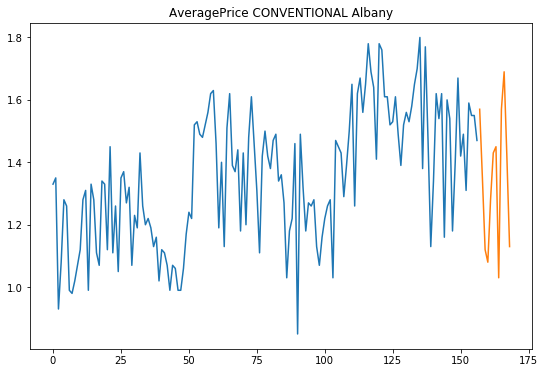

In [41]:
plot_seris('Albany','conventional')

# Prepare dataset for modelling

In [72]:
sequence_length = 4

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [73]:
X_train_c, X_train_o = [], []
X_test_c, X_test_o = [], []
X_other_train_c, X_other_train_o = [], []
X_other_test_c, X_other_test_o = [], []

for county in df["region"].unique(): 
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                                 sequence_length, ['AveragePrice']):
        X_train_c.append(sequence) if county != 'Albany' else X_other_train_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                                 sequence_length, ['AveragePrice']):
        X_train_o.append(sequence) if county != 'Albany' else X_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        X_test_c.append(sequence) if county != 'Albany' else X_other_test_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        X_test_o.append(sequence) if county != 'Albany' else X_other_test_o.append(sequence)
        
y_train_c, y_train_o = [], []
y_test_c, y_test_o = [], []
y_other_train_c, y_other_train_o = [], []
y_other_test_c, y_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                               sequence_length, ['AveragePrice']):
        y_train_c.append(sequence) if county != 'Albany' else y_other_train_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                               sequence_length, ['AveragePrice']):
        y_train_o.append(sequence) if county != 'Albany' else y_other_train_o.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        y_test_c.append(sequence) if county != 'Albany' else y_other_test_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        y_test_o.append(sequence) if county != 'Albany' else y_other_test_o.append(sequence)

y_train_c, y_train_o = np.asarray(y_train_c), np.asarray(y_train_o)
y_test_c, y_test_o = np.asarray(y_test_c), np.asarray(y_test_o)
y_other_train_c, y_other_train_o = np.asarray(y_other_train_c), np.asarray(y_other_train_o)
y_other_test_c, y_other_test_o = np.asarray(y_other_test_c), np.asarray(y_other_test_o)

In [74]:
X = np.concatenate([X_train_c,X_train_o,X_test_c,X_test_o],axis=0)
y = np.concatenate([y_train_c,y_train_o,y_test_c,y_test_o],axis=0)

print(X.shape,y.shape)

(17063, 4, 1) (17063, 1)


In [75]:
col = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
 
f_train_c, f_train_o = [], []
f_test_c, f_test_o = [], []
f_other_train_c, f_other_train_o = [], []
f_other_test_c, f_other_test_o = [], []

for county in df["region"].unique():
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                                 sequence_length, col):
        f_train_c.append(sequence) if county != 'Albany' else f_other_train_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                                 sequence_length, col):
        f_train_o.append(sequence) if county != 'Albany' else f_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                                 sequence_length, col):
        f_test_c.append(sequence) if county != 'Albany' else f_other_test_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                                 sequence_length, col):
        f_test_o.append(sequence) if county != 'Albany' else f_other_test_o.append(sequence)
    
f_train_c, f_train_o = np.asarray(f_train_c), np.asarray(f_train_o)
f_test_c, f_test_o = np.asarray(f_test_c), np.asarray(f_test_o)
f_other_train_c, f_other_train_o = np.asarray(f_other_train_c), np.asarray(f_other_train_o)
f_other_test_c, f_other_test_o = np.asarray(f_other_test_c), np.asarray(f_other_test_o)

In [76]:
F = np.concatenate([f_train_c,f_train_o,f_test_c,f_test_o],axis=0)

print(F.shape)

(17063, 4, 8)


## Forecast + Autoencoder

In [77]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### DEFINE LSTM AUTOENCODER ###
inputs_ae = Input(shape=(sequence_length, 1))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

### TRAIN AUTOENCODER ###
sequence_autoencoder.fit(X[:len(X_train_c)+len(X_train_o)], X[:len(X_train_c)+len(X_train_o)], 
                         batch_size=128, epochs=100, verbose=2, shuffle=True)

Epoch 1/100
127/127 - 3s - loss: 0.5281 - mse: 0.5281
Epoch 2/100
127/127 - 3s - loss: 0.1467 - mse: 0.1467
Epoch 3/100
127/127 - 3s - loss: 0.1096 - mse: 0.1096
Epoch 4/100
127/127 - 2s - loss: 0.0744 - mse: 0.0744
Epoch 5/100
127/127 - 1s - loss: 0.0556 - mse: 0.0556
Epoch 6/100
127/127 - 1s - loss: 0.0457 - mse: 0.0457
Epoch 7/100
127/127 - 2s - loss: 0.0412 - mse: 0.0412
Epoch 8/100
127/127 - 1s - loss: 0.0384 - mse: 0.0384
Epoch 9/100
127/127 - 1s - loss: 0.0363 - mse: 0.0363
Epoch 10/100
127/127 - 1s - loss: 0.0335 - mse: 0.0335
Epoch 11/100
127/127 - 1s - loss: 0.0322 - mse: 0.0322
Epoch 12/100
127/127 - 2s - loss: 0.0319 - mse: 0.0319
Epoch 13/100
127/127 - 2s - loss: 0.0297 - mse: 0.0297
Epoch 14/100
127/127 - 1s - loss: 0.0302 - mse: 0.0302
Epoch 15/100
127/127 - 1s - loss: 0.0293 - mse: 0.0293
Epoch 16/100
127/127 - 1s - loss: 0.0292 - mse: 0.0292
Epoch 17/100
127/127 - 1s - loss: 0.0290 - mse: 0.0290
Epoch 18/100
127/127 - 1s - loss: 0.0272 - mse: 0.0272
Epoch 19/100
127/12

In [78]:
encoder = Model(inputs_ae, encoded_ae)
XX = encoder.predict(X)
XXF = np.concatenate([XX, F], axis=2)
XXF.shape

(17063, 4, 136)

In [80]:
X_train1, X_test1 = XXF[:len(X_train_c)+len(X_train_o)], XXF[len(X_train_c)+len(X_train_o):]
y_train1, y_test1 = y[:len(y_train_c)+len(y_train_o)], y[len(y_train_c)+len(y_train_o):]

In [81]:
scaler1 = StandardScaler()
X_train1 = scaler1.fit_transform(X_train1.reshape(-1,XXF.shape[-1])).reshape(-1,sequence_length,XXF.shape[-1])
X_test1 = scaler1.transform(X_test1.reshape(-1,XXF.shape[-1])).reshape(-1,sequence_length,XXF.shape[-1])

In [82]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### DEFINE FORECASTER ###
inputs1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
lstm1 = LSTM(128, return_sequences=True, dropout=0.3)(inputs1, training=True)
lstm1 = LSTM(32, return_sequences=False, dropout=0.3)(lstm1, training=True)
dense1 = Dense(50)(lstm1)
out1 = Dense(1)(dense1)

model1 = Model(inputs1, out1)
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])

### FIT FORECASTER ###
history = model1.fit(X_train1, y_train1, epochs=30, batch_size=128, verbose=2, shuffle=True)

Epoch 1/30
127/127 - 2s - loss: 0.1139 - mse: 0.1139
Epoch 2/30
127/127 - 2s - loss: 0.0365 - mse: 0.0365
Epoch 3/30
127/127 - 2s - loss: 0.0351 - mse: 0.0351
Epoch 4/30
127/127 - 2s - loss: 0.0344 - mse: 0.0344
Epoch 5/30
127/127 - 2s - loss: 0.0342 - mse: 0.0342
Epoch 6/30
127/127 - 2s - loss: 0.0338 - mse: 0.0338
Epoch 7/30
127/127 - 2s - loss: 0.0340 - mse: 0.0340
Epoch 8/30
127/127 - 2s - loss: 0.0335 - mse: 0.0335
Epoch 9/30
127/127 - 2s - loss: 0.0331 - mse: 0.0331
Epoch 10/30
127/127 - 2s - loss: 0.0333 - mse: 0.0333
Epoch 11/30
127/127 - 2s - loss: 0.0332 - mse: 0.0332
Epoch 12/30
127/127 - 2s - loss: 0.0328 - mse: 0.0328
Epoch 13/30
127/127 - 2s - loss: 0.0329 - mse: 0.0329
Epoch 14/30
127/127 - 2s - loss: 0.0325 - mse: 0.0325
Epoch 15/30
127/127 - 2s - loss: 0.0325 - mse: 0.0325
Epoch 16/30
127/127 - 2s - loss: 0.0324 - mse: 0.0324
Epoch 17/30
127/127 - 2s - loss: 0.0326 - mse: 0.0326
Epoch 18/30
127/127 - 2s - loss: 0.0326 - mse: 0.0326
Epoch 19/30
127/127 - 3s - loss: 0.03

In [83]:
def stoc_drop1(R, enc, NN):
    
    enc_pred = np.vstack(enc([X[len(X_train_c)+len(X_train_o):], R]))
    enc_pred = np.concatenate([enc_pred, F[len(X_train_c)+len(X_train_o):]], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred)

In [84]:
scores1 = []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    scores1.append(mean_absolute_error(y_test1, stoc_drop1(0.5, enc, NN)))

print(np.mean(scores1), np.std(scores1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.13it/s]

0.12228441143108988 0.0017645477640543367


## Simple forecast

In [85]:
XF = np.concatenate([X, F], axis=2)
print(XF.shape)

(17063, 4, 9)


In [86]:
X_train2, X_test2 = XF[:len(X_train_c)+len(X_train_o)], XF[len(X_train_c)+len(X_train_o):]
y_train2, y_test2 = y[:len(y_train_c)+len(y_train_o)], y[len(y_train_c)+len(y_train_o):]

In [87]:
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2.reshape(-1,X_train2.shape[-1])).reshape(-1,sequence_length,X_train2.shape[-1])
X_test2 = scaler2.transform(X_test2.reshape(-1,X_train2.shape[-1])).reshape(-1,sequence_length,X_train2.shape[-1])

In [88]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### DEFINE LSTM FORECASTER ###
inputs2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
lstm2 = LSTM(128, return_sequences=True, dropout=0.3)(inputs2, training=True)
lstm2 = LSTM(32, return_sequences=False, dropout=0.3)(lstm2, training=True)
dense2 = Dense(50)(lstm2)
out2 = Dense(1)(dense2)

model2 = Model(inputs2, out2)
model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

### FIT FORECASTER ###
history = model2.fit(X_train2, y_train2, epochs=30, batch_size=128, verbose=2, shuffle=True)

Epoch 1/30
127/127 - 1s - loss: 0.2602 - mse: 0.2602
Epoch 2/30
127/127 - 1s - loss: 0.0470 - mse: 0.0470
Epoch 3/30
127/127 - 1s - loss: 0.0446 - mse: 0.0446
Epoch 4/30
127/127 - 1s - loss: 0.0436 - mse: 0.0436
Epoch 5/30
127/127 - 1s - loss: 0.0427 - mse: 0.0427
Epoch 6/30
127/127 - 1s - loss: 0.0417 - mse: 0.0417
Epoch 7/30
127/127 - 1s - loss: 0.0419 - mse: 0.0419
Epoch 8/30
127/127 - 1s - loss: 0.0410 - mse: 0.0410
Epoch 9/30
127/127 - 1s - loss: 0.0403 - mse: 0.0403
Epoch 10/30
127/127 - 1s - loss: 0.0398 - mse: 0.0398
Epoch 11/30
127/127 - 1s - loss: 0.0399 - mse: 0.0399
Epoch 12/30
127/127 - 1s - loss: 0.0385 - mse: 0.0385
Epoch 13/30
127/127 - 1s - loss: 0.0386 - mse: 0.0386
Epoch 14/30
127/127 - 1s - loss: 0.0385 - mse: 0.0385
Epoch 15/30
127/127 - 1s - loss: 0.0378 - mse: 0.0378
Epoch 16/30
127/127 - 1s - loss: 0.0387 - mse: 0.0387
Epoch 17/30
127/127 - 1s - loss: 0.0373 - mse: 0.0373
Epoch 18/30
127/127 - 1s - loss: 0.0371 - mse: 0.0371
Epoch 19/30
127/127 - 1s - loss: 0.03

In [89]:
def stoc_drop2(R, NN):
    
    trans_pred = scaler2.transform(XF[len(X_train_c)+len(X_train_o):].reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN([trans_pred,R])
    
    return np.vstack(NN_pred)

In [90]:
scores2 = []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    scores2.append(mean_absolute_error(y_test2, stoc_drop2(0.5, NN)))

print(np.mean(scores2), np.std(scores2))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.32it/s]

0.13159476308306717 0.0021927159858375796


# Compared Results

In [91]:
def test_county(county):
    
    test_X_c, test_X_o = [], []
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        test_X_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        test_X_o.append(sequence)
        
    test_X_c, test_X_o = np.asarray(test_X_c), np.asarray(test_X_o)
    
    test_y_c, test_y_o = [], []
    
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        test_y_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                               sequence_length, ['AveragePrice']):
        test_y_o.append(sequence)
        
    test_y_c, test_y_o = np.asarray(test_y_c), np.asarray(test_y_o)
    
    test_F_c, test_F_o = [], []
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, col):
        test_F_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                                 sequence_length, col):
        test_F_o.append(sequence)
        
    test_F_c, test_F_o = np.asarray(test_F_c), np.asarray(test_F_o)
    
    X = np.concatenate([test_X_c,test_X_o],axis=0)
    y = np.concatenate([test_y_c,test_y_o],axis=0)
    F = np.concatenate([test_F_c,test_F_o],axis=0)
    
    return X, y, F

In [92]:
def test_stoc_drop1(county, R, enc, NN):
    
    X, y, F = test_county(county)
    
    enc_pred = np.vstack(enc([X, R]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y


def test_stoc_drop2(county, R, NN):
    
    X, y, F = test_county(county)
    
    XF = np.concatenate([X, F], axis=2)
    trans_pred = scaler2.transform(XF.reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y

In [93]:
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])
pred1_test, y1_test = test_stoc_drop1('TotalUS', 0.5, enc, NN)

In [94]:
mae1_test = []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    mae1_test.append(mean_absolute_error(y1_test, test_stoc_drop1('TotalUS', 0.5, enc, NN)[0]))

print(np.mean(mae1_test), np.std(mae1_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.61it/s]

0.07468783167898656 0.010119802898604965


In [95]:
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])
pred2_test, y2_test = test_stoc_drop2('TotalUS', 0.5, NN)

In [96]:
mae2_test = []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    mae2_test.append(mean_absolute_error(y2_test, test_stoc_drop2('TotalUS', 0.5, NN)[0]))

print(np.mean(mae2_test), np.std(mae2_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.78it/s]

0.11173290429562327 0.017923403230460808


Text(0.5, 1.0, 'TotalUS')

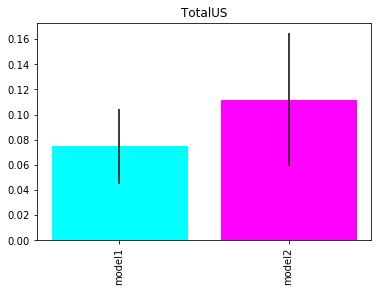

In [97]:
bar = plt.bar([0,1], [np.mean(mae1_test), np.mean(mae2_test)], 
              yerr=[2.95*np.std(mae1_test), 2.95*np.std(mae2_test)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('TotalUS')

# Test on Sales Data

  Loading BIODIESEL B10 data ...
  Generate time series features ...
    Understand the mean and standard deviation of time series data for better understanding on the data ...
    Moving average on 7 and 21 period size ...
    Moving average convergence divergence ...
    Bollinger band ...
    Rate of change ...
    Exponential moving average ...
    Momentum ...
  Extract time series feature in frequency domain ...
  Prepare time series feature to the right format ...
  Saving  Biodiesel dataframe to file 'data_local\biodiesel_B10.csv' ...
  done.


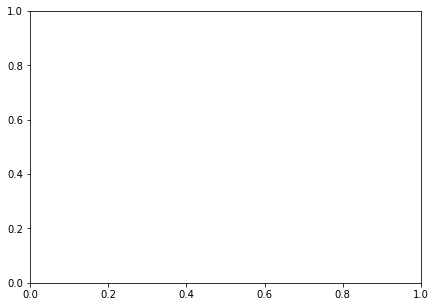

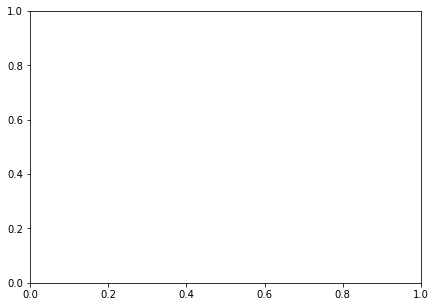

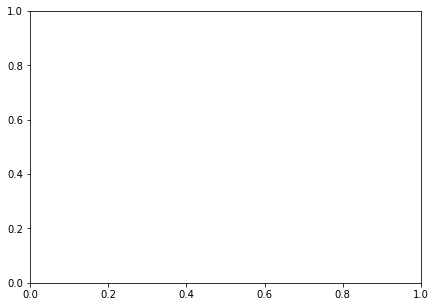

In [100]:
analysis = Analysis()

analysis.get_biodiesel()